# Imports

In [51]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import community as community_louvain
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from random import uniform

In [52]:
#seeds for reproducibility
np.random.seed(42)

## Load Part of Speech file

In [53]:
with open("files/pos_tags.json", "r", encoding="utf-8") as f:
    pos_tags = json.load(f)

## Load pairs file to create graphs

In [54]:
def load_weighted_graph_pmi(file, genders= None):
    """Function to load a weighted graph from a file and compute PPMI weights for the edges.
    Args:
        file (str): path to the file containing weighted edges in the format "node1,node2,weight
        genders (list): list of genders to exclude from the graph  
         Returns:
         G (networkx.Graph): graph with PPMI weights on edges
         """
    # Counters to store node and co-occurrence counts for PMI calculation
    node_counts = Counter()
    co_occurrence_counts = Counter()

    # Read the file and populate the counters
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) != 3:
                continue
            node1, node2, weight = parts
            weight = int(weight)

            node_counts[node1] += weight
            node_counts[node2] += weight
            co_occurrence_counts[(node1, node2)] += weight

    # Total number of co-occurrences
    total_count = sum(co_occurrence_counts.values())
    pmi_values = {}

    # Compute PPMI, this ensures no negative values 
    pmi_values = {}
    for (node1, node2), co_count in co_occurrence_counts.items():
        p_node1 = node_counts[node1] / total_count #probability of node1
        p_node2 = node_counts[node2] / total_count #probability of node2
        p_co = co_count / total_count #joint probability
        # PMI calculation with small constant to avoid log(0)
        pmi = np.log2((p_co + 1e-8) / (p_node1 * p_node2))
        pmi_values[(node1, node2)] = max(pmi, 0)  # Store only non-negative PMI values
    
    G = nx.Graph()
    for (node1, node2), pmi in pmi_values.items():
        #we filter edges based on gender, so if either node belongs to the excluded genders, we skip adding that edge
        if not (pos_tags[node1]["gender"] in genders or pos_tags[node2]["gender"] in genders):
            G.add_edge(node1, node2, pmi=pmi)
            for w in (node1, node2):
                if w in pos_tags:
                    G.nodes[w]['pos'] = pos_tags[w]['pos']
                    G.nodes[w]['gender'] = pos_tags[w]['gender']
                else:
                    G.nodes[w]["pos"] = None
                    G.nodes[w]["gender"] = None
    return G

G_male = load_weighted_graph_pmi("files/male_pairs_w.txt", ["female"])
G_female = load_weighted_graph_pmi("files/female_pairs_w.txt", ["male"])

## EDA

In [55]:
print("Number of nodes in male network:", G_male.number_of_nodes())
print("Number of nodes in female network:", G_female.number_of_nodes())

print("\nNumber of edges in male network:", G_male.number_of_edges())
print("Number of edges in female network:", G_female.number_of_edges())

print("\nAverage degree in male network:", np.mean([d for n, d in G_male.degree()]))
print("Average degree in female network:", np.mean([d for n, d in G_female.degree()]))

print("\nMinimum degree in the male netowrk:", np.min([d for n, d in G_male.degree()]))
print("Minimum degree in the female netowrk:", np.min([d for n, d in G_female.degree()]))

print("\nMaximum degree in the male netowrk:", np.max([d for n, d in G_male.degree()]))
print("Maximum degree in the female netowrk:", np.max([d for n, d in G_female.degree()]))

print("\nDensity of male network:", nx.density(G_male))
print("Density of female network:", nx.density(G_female))

print("\nTop 5 nodes with highest degree in male network:")
for node, degree in sorted(G_male.degree(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"- {node}: {degree}")
print("Top 5 nodes with highest degree in female network:")
for node, degree in sorted(G_female.degree(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"- {node}: {degree}")

Number of nodes in male network: 9419
Number of nodes in female network: 4283

Number of edges in male network: 200232
Number of edges in female network: 47976

Average degree in male network: 42.51661535194819
Average degree in female network: 22.402988559420965

Minimum degree in the male netowrk: 1
Minimum degree in the female netowrk: 2

Maximum degree in the male netowrk: 1582
Maximum degree in the female netowrk: 570

Density of male network: 0.004514399591415183
Density of female network: 0.005231898309066083

Top 5 nodes with highest degree in male network:
- take: 1582
- find: 1546
- return: 1256
- help: 1204
- give: 1202
Top 5 nodes with highest degree in female network:
- find: 570
- take: 525
- return: 395
- leave: 388
- give: 386


### We investigate which edges have the highest PMI in each graph

In [56]:
# Top 20 edges with highest PMI
top_20_pmi_male = sorted(G_male.edges(data="pmi"), key=lambda x: x[2], reverse=True)[:20]
top_20_pmi_female = sorted(G_female.edges(data="pmi"), key=lambda x: x[2], reverse=True)[:20]

print("Top 20 edges with highest PMI in males:" )
for e in top_20_pmi_male:
    print(e)
print("-----"*20)
print("\nTop 20 edges with highest PMI in females:" )
for e_ in top_20_pmi_female:
    print(e_)  

Top 20 edges with highest PMI in males:
('pastoral', 'symphony', np.float64(18.190526967033467))
('fugue', 'toccata', np.float64(16.190526967033467))
('application', 'submit', np.float64(16.190526967033467))
('gladly', 'whomever', np.float64(15.020601965591155))
('sedate', 'concrete', np.float64(15.020601965591155))
('coagent', 'stammer', np.float64(15.020601965591155))
('stocky', 'ox', np.float64(14.190526967033467))
('beer', 'sniper', np.float64(14.190526967033467))
('cold', 'hearted', np.float64(14.190526967033467))
('preoccupy', 'mindedly', np.float64(14.190526967033467))
('procleveland', 'staunch', np.float64(14.190526967033467))
('procleveland', 'democrat', np.float64(14.190526967033467))
('staunch', 'democrat', np.float64(14.190526967033467))
('billionaire', 'jw', np.float64(14.190526967033467))
('patriarch', 'billy-graingerford', np.float64(14.190526967033467))
('xianniang', 'snipe', np.float64(14.190526967033467))
('preference', 'indifferent', np.float64(14.190526967033467))
(

### Top 20 nodes by their degree centrality per graph

In [57]:
def top_20_by_degree_centrality(G, gender):
    """Funtion to compute and print the top 20 nodes by degree centrality in a graph.
    Args:
        G (networkx.Graph): input graph
        gender (str): gender associated with the graph"""
    degree_centrality = nx.degree_centrality(G)
    sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 20 nodes by degree centrality in {gender}-associated graph:")
    for node, centrality in sorted_nodes[:20]:
        print(f"Node: {node}, Degree Centrality: {centrality:.4f}")

In [58]:
top_20_by_degree_centrality(G_male, "male")
top_20_by_degree_centrality(G_female, "female")

Top 20 nodes by degree centrality in male-associated graph:
Node: take, Degree Centrality: 0.1680
Node: find, Degree Centrality: 0.1642
Node: return, Degree Centrality: 0.1334
Node: help, Degree Centrality: 0.1278
Node: give, Degree Centrality: 0.1276
Node: name, Degree Centrality: 0.1262
Node: leave, Degree Centrality: 0.1260
Node: use, Degree Centrality: 0.1249
Node: friend, Degree Centrality: 0.1238
Node: go, Degree Centrality: 0.1234
Node: back, Degree Centrality: 0.1217
Node: tell, Degree Centrality: 0.1206
Node: reveal, Degree Centrality: 0.1199
Node: become, Degree Centrality: 0.1142
Node: make, Degree Centrality: 0.1140
Node: get, Degree Centrality: 0.1116
Node: discover, Degree Centrality: 0.1107
Node: father, Degree Centrality: 0.1071
Node: try, Degree Centrality: 0.1067
Node: escape, Degree Centrality: 0.1032
Top 20 nodes by degree centrality in female-associated graph:
Node: find, Degree Centrality: 0.1331
Node: take, Degree Centrality: 0.1226
Node: return, Degree Centralit

## Plots

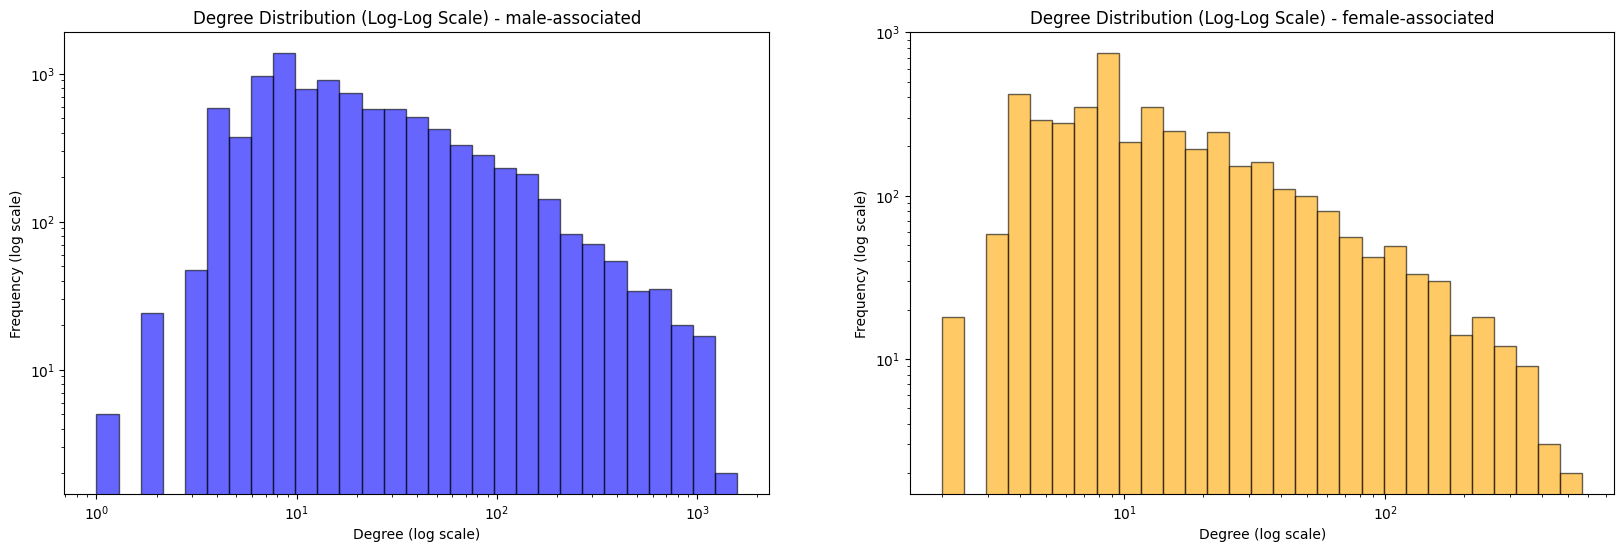

In [74]:
def plot_degree_dist_log(graph_male, graph_female):
    """Function to plot the degree distribution of two graphs on a log-log scale.
    """
    degrees_male = list(dict(graph_male.degree()).values())
    degrees_female = list(dict(graph_female.degree()).values())
    
    plt.figure(figsize=(20,6))
    plt.subplot(1, 2, 1)
    plt.hist(degrees_male, bins=np.logspace(np.log10(min(degrees_male)), np.log10(max(degrees_male)), 30), color='blue', alpha=0.6, edgecolor='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Degree Distribution (Log-Log Scale) - male-associated')

    plt.subplot(1, 2, 2)
    plt.hist(degrees_female, bins=np.logspace(np.log10(min(degrees_female)), np.log10(max(degrees_female)), 30), color='orange', alpha=0.6, edgecolor='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Degree Distribution (Log-Log Scale) - female-associated')
    plt.savefig("plots/degree_distribution_log_log.png")
    plt.show()
plot_degree_dist_log(G_male,G_female)


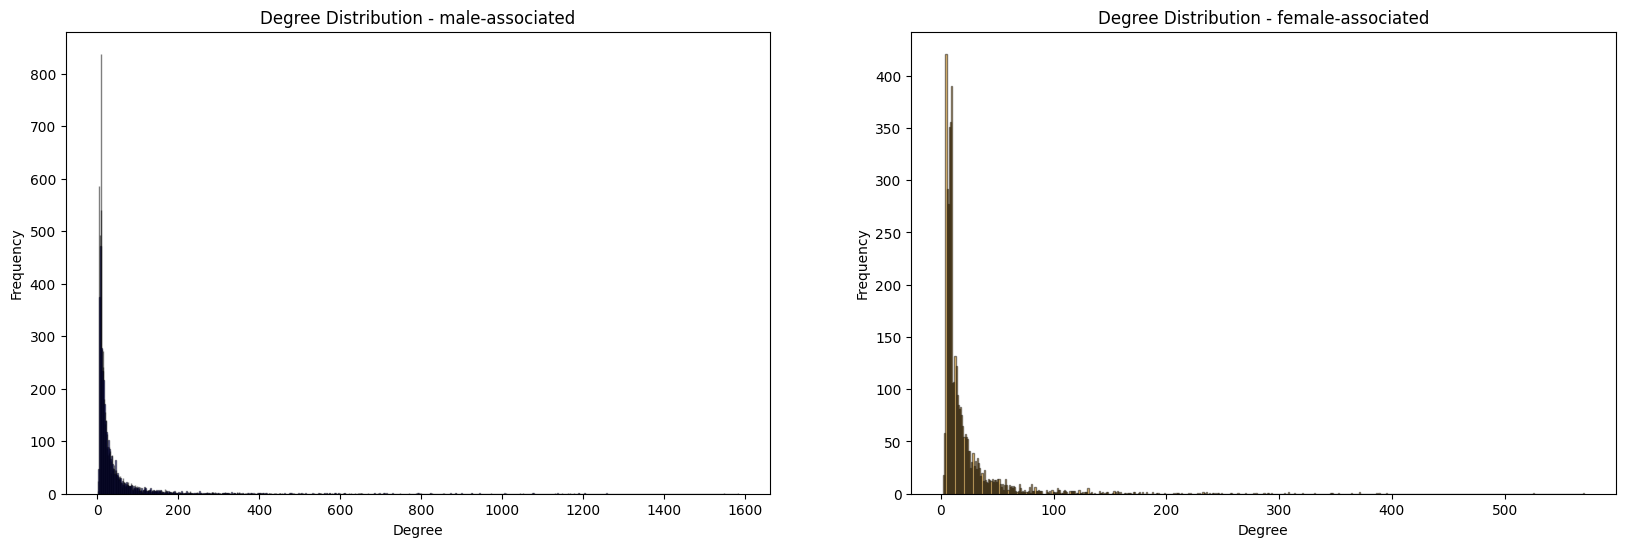

In [73]:
def plot_degree_dist(graph_male, graph_female):
    """Function to plot the degree distribution of two graphs.
    """
    degree_male = dict(graph_male.degree())
    min_degree_m, max_degree_m = min(degree_male.values()), max(degree_male.values())
    degree_vector_m = np.arange(min_degree_m, max_degree_m + 1)
    degree_hist_m = np.histogram(list(degree_male.values()), bins=degree_vector_m)

    degree_female = dict(graph_female.degree()) 
    min_degree_f, max_degree_f = min(degree_female.values()), max(degree_female.values())
    degree_vector_f = np.arange(min_degree_f, max_degree_f + 1)
    degree_hist_f = np.histogram(list(degree_female.values()), bins=degree_vector_f)



    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.hist(degree_male.values(), bins=degree_hist_m[1], color='blue', alpha=0.5, edgecolor='black')
    plt.title('Degree Distribution - male-associated')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.subplot(1, 2, 2)
    plt.hist(degree_female.values(), bins=degree_hist_f[1], color='orange', alpha=0.5, edgecolor='black')
    plt.title('Degree Distribution - female-associated')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.savefig("plots/degree_distribution.png")
    plt.show()

plot_degree_dist(G_male, G_female)


## Connected Component

In [61]:
def get_connected_component(graph):
    """Function to get the largest connected component of a graph.
    Args:
        graph (networkx.Graph): input graph
        Returns:
            largest connected component (networkx.Graph)
            """
    #get connected components
    connected_components = list(nx.connected_components(graph))
    print(f"Number of connected components: {len(connected_components)}")
    largest_cc = max(connected_components, key=len)
    G_largest = graph.subgraph(largest_cc)
    print(f"Largest connected component size: {G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges")
    return G_largest

m_largest= get_connected_component(G_male)
f_largest= get_connected_component(G_female)

Number of connected components: 2
Largest connected component size: 9417 nodes, 200231 edges
Number of connected components: 2
Largest connected component size: 4278 nodes, 47966 edges


## Community Detection

We use the pmi score to compute the louvain partitions

In [64]:
def detect_communities(graph):
    """Detect communities in the graph using the Louvain method and we calculate modularity.
    Args:
        graph (networkx.Graph): input graph
        Returns:
            partition (dict): mapping of node to community ID
            top_community_ids (list): IDs of the 4 largest communities
            community_vectors (dict): centroid vectors for each community
        """
    # Perform community detection
    partition = community_louvain.best_partition(graph, weight='pmi')
    num_communities = len(set(partition.values()))
    print(f"Number of communities detected: {num_communities}")

    # Get sizes of communities
    partition_sizes = Counter(partition.values())
    largest_partitions = partition_sizes.most_common(4)
    top_community_ids = [comm_id for comm_id, size in largest_partitions]
    print("Sizes of the 4 largest communities:")
    print(sorted(largest_partitions, key=lambda x: x[1], reverse=True))
            
    #calculate modularity
    modularity = community_louvain.modularity(partition, graph, weight='pmi')
    print(f"Modularity of the partition: {modularity:.4f}")
    
    return partition, top_community_ids

In [65]:
m_communities, m_communities_ids = detect_communities(m_largest)
f_communities, f_communities_ids = detect_communities(f_largest)

Number of communities detected: 35
Sizes of the 4 largest communities:
[(1, 427), (0, 419), (24, 409), (25, 398)]
Modularity of the partition: 0.2956
Number of communities detected: 30
Sizes of the 4 largest communities:
[(11, 269), (10, 245), (22, 228), (2, 214)]
Modularity of the partition: 0.4261


### Add community as attribute to each node

In [66]:
for node, comm_id in m_communities.items():
    m_largest.nodes[node]['community'] = comm_id
for node, comm_id in f_communities.items():
    f_largest.nodes[node]['community'] = comm_id

### Community plot

In [71]:
def plot_top_communities_side_by_side(graph1, graph2, top_community_ids1, top_community_ids2, title1, title2):
    """
    Plots two filtered networks side by side for comparison.
    Only nodes in top communities that are VERB or ADJ are shown.
    No node labels for clarity. Communities are colored.
    Args:
        graph1 (networkx.Graph): First input graph
        graph2 (networkx.Graph): Second input graph
        top_community_ids1 (list): List of top community IDs for the first graph
        top_community_ids2 (list): List of top community IDs for the second graph
        title1 (str): Title for the first graph
        title2 (str): Title for the second graph    
    """
    # Helper function to filter only nodes in top communities and with POS VERB or ADJ
    def filter_top_nodes(graph, top_community_ids):
        return [
            n for n, d in graph.nodes(data=True)
            if d.get('community') in top_community_ids and d.get('pos') in ['VERB', 'ADJ']
        ]
    
    # Filter nodes
    nodes1 = filter_top_nodes(graph1, top_community_ids1)
    nodes2 = filter_top_nodes(graph2, top_community_ids2)
    
    G1 = graph1.subgraph(nodes1).copy()
    G2 = graph2.subgraph(nodes2).copy()
    #remove isolated nodes
    for node in list(G1.nodes):
        if G1.degree(node) == 0:
            G1.remove_node(node)
    for node in list(G2.nodes):
        if G2.degree(node) == 0:
            G2.remove_node(node)
    
    # Layouts
    pos1 = nx.spring_layout(G1, k=0.5, iterations=100)
    pos2 = nx.spring_layout(G2, k=0.5, iterations=100)
    
    # Node and edge settings
    node_size = 100
    edge_color = 'gray'
    edge_width = 0.5
    colors = ["#890505", "#095199", "#047604", "#8b4602"]  
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Draw first graph
    for i, comm_id in enumerate(top_community_ids1):
        nodes = [n for n, d in G1.nodes(data=True) if d['community'] == comm_id]
        if nodes:
            nx.draw_networkx_nodes(
                G1, pos1, nodelist=nodes,
                node_color=colors[i % len(colors)],
                node_size=node_size, ax=axes[0]
            )
    nx.draw_networkx_edges(G1, pos1, edge_color=edge_color, width=edge_width, ax=axes[0])
    axes[0].set_title(title1, fontsize=24)
    axes[0].axis('off')
    
    # Draw second graph
    for i, comm_id in enumerate(top_community_ids2):
        nodes = [n for n, d in G2.nodes(data=True) if d['community'] == comm_id]
        if nodes:
            nx.draw_networkx_nodes(
                G2, pos2, nodelist=nodes,
                node_color=colors[i % len(colors)],
                node_size=node_size, ax=axes[1]
            )
    nx.draw_networkx_edges(G2, pos2, edge_color=edge_color, width=edge_width, ax=axes[1])
    axes[1].set_title(title2, fontsize=24)
    axes[1].axis('off')
    
    plt.tight_layout()
    #save the figure
    plt.savefig("plots/top_4_communities_side_by_side.png")
    plt.show()


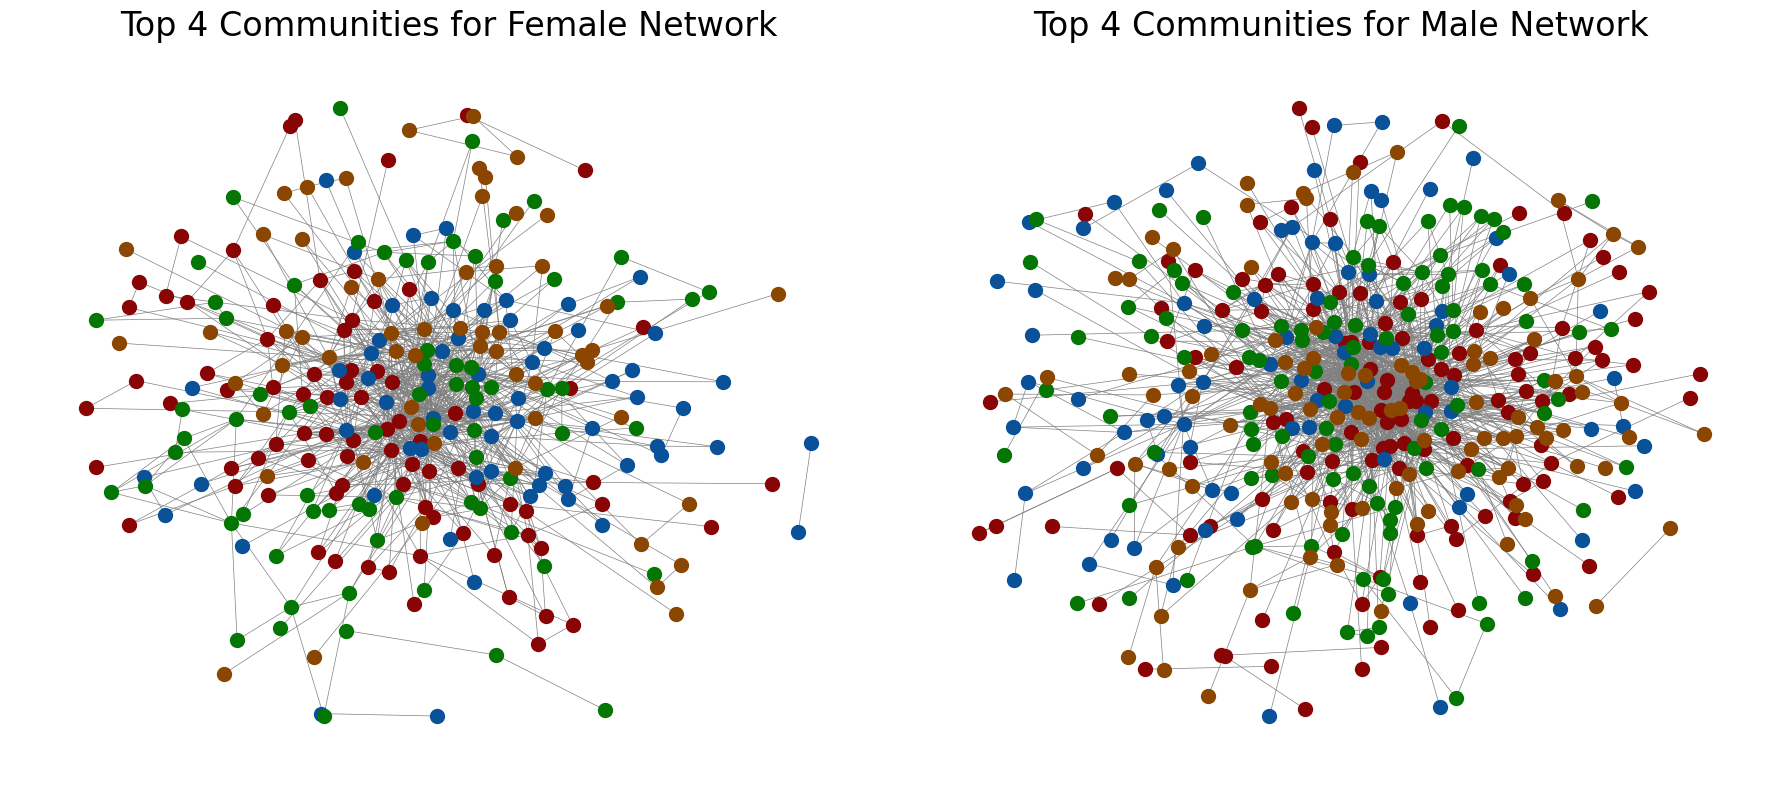

In [72]:
plot_top_communities_side_by_side(
    f_largest, m_largest,
    f_communities_ids, m_communities_ids,
    "Top 4 Communities for Female Network", "Top 4 Communities for Male Network"
)


### Community wordclouds

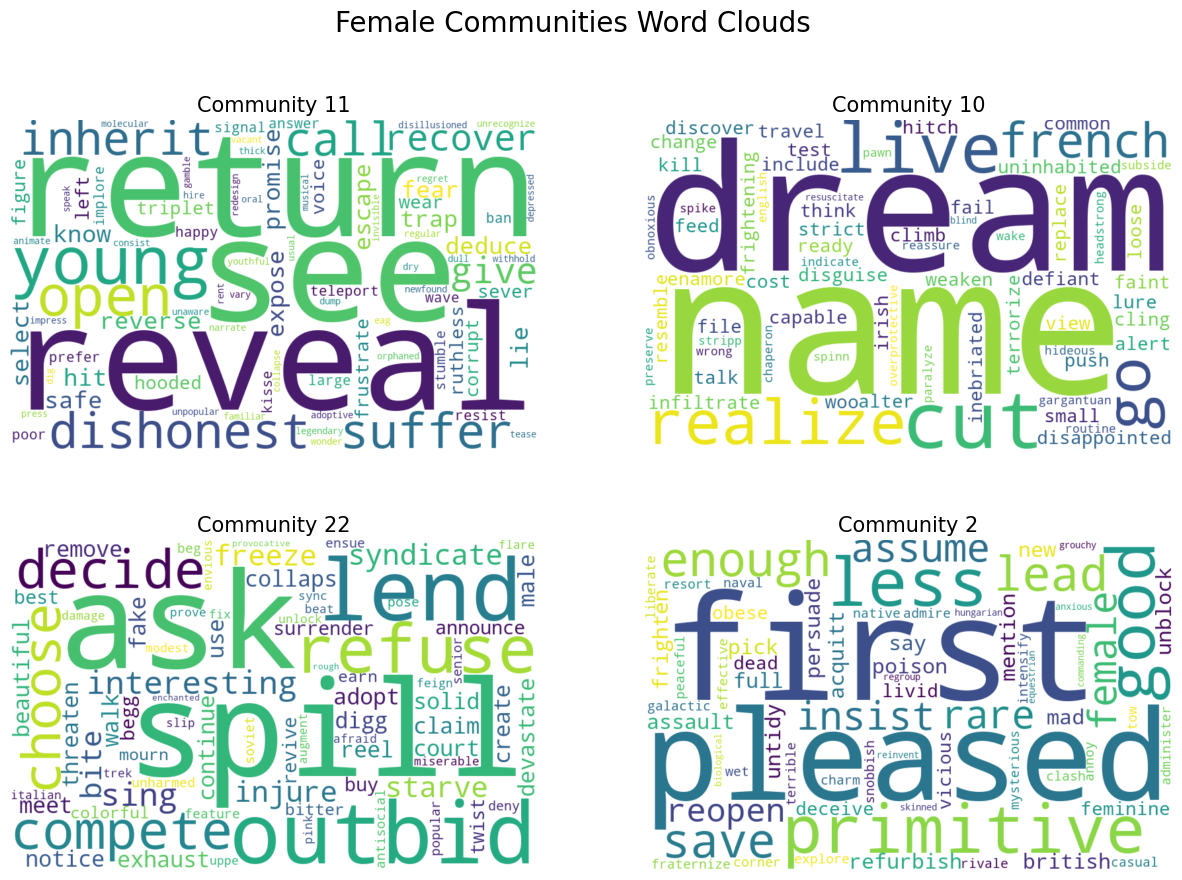

In [69]:
#we create a dict with the community and all the nodes from f_largest
top_nodes_per_f_comm_dict = {}
for comm_id in f_communities_ids:
    nodes = [n for n, d in f_largest.nodes(data=True) if d['community'] == comm_id]
    comm_nodes = [n for n in f_largest if n in nodes]
    top_nodes_per_f_comm_dict[comm_id] = comm_nodes
    
#word clouds for each community
i = 0
plt.figure(figsize=(15, 10))
plt.suptitle("Female Communities Word Clouds", size=20)
for comm_id, nodes in top_nodes_per_f_comm_dict.items():
    top_nodes = [n for n in nodes if f_largest.nodes[n].get('pos') in ['VERB', 'ADJ']]
    words = ' '.join(top_nodes)
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate(words)
    plt.subplot(2, 2, i+1)
    plt.title(f"Community {comm_id}", size=15)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    i += 1
#save the figure
plt.savefig("plots/female_communities_wordclouds.png")

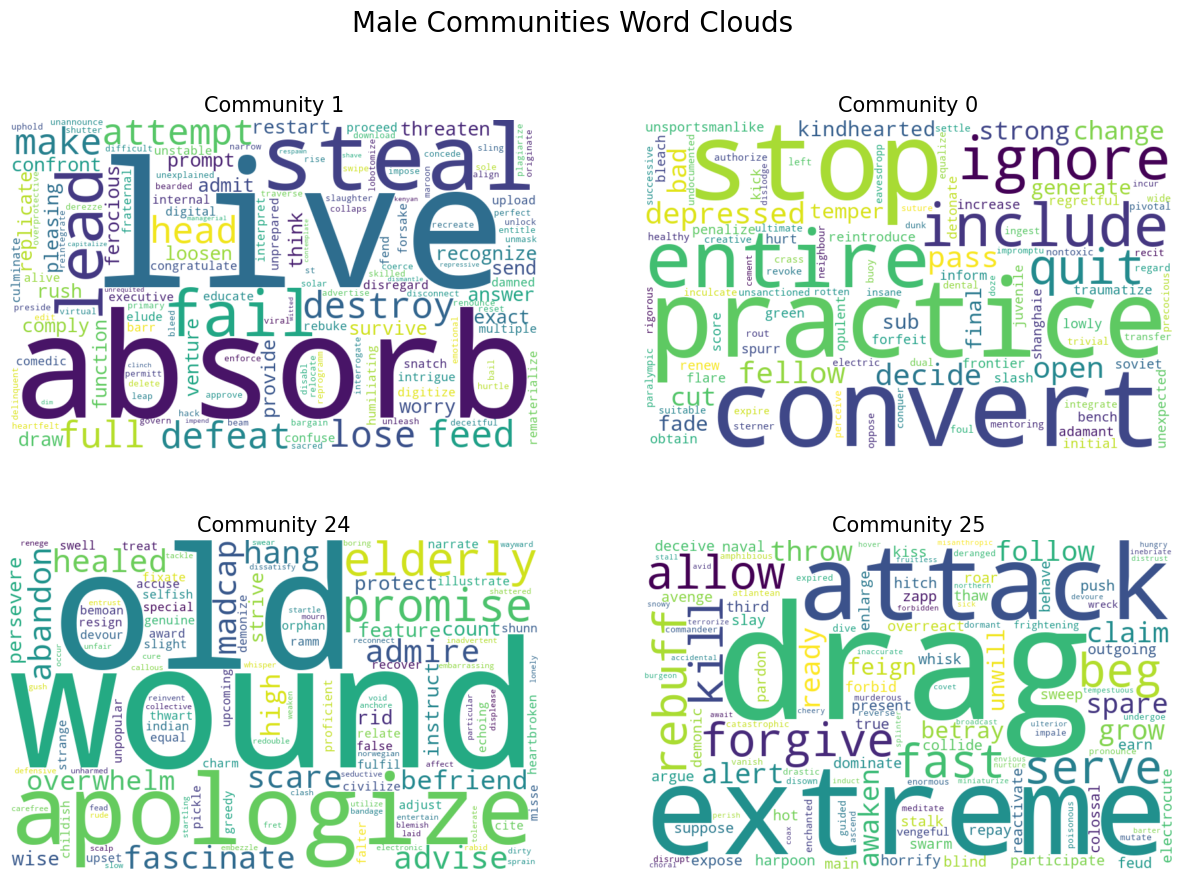

In [70]:
#we create a dict with the community and all the nodes from f_largest
top_nodes_per_m_comm_dict = {}
for comm_id in m_communities_ids:
    nodes = [n for n, d in m_largest.nodes(data=True) if d['community'] == comm_id]
    comm_nodes = [n for n in m_largest if n in nodes]
    top_nodes_per_m_comm_dict[comm_id] = comm_nodes
#word clouds for each community
i = 0
plt.figure(figsize=(15, 10))
plt.suptitle("Male Communities Word Clouds", size=20)
for comm_id, nodes in top_nodes_per_m_comm_dict.items():
    top_nodes = [n for n in nodes if m_largest.nodes[n].get('pos') in ['VERB', 'ADJ']]
    words = ' '.join(top_nodes)
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate(words)
    #create a 2x2 subplot for the 4 communities
    plt.subplot(2, 2, i+1)
    plt.title(f"Community {comm_id}", size=15)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    i += 1
#save the figure
plt.savefig("plots/male_communities_wordclouds.png")